In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torchvision.datasets import ImageFolder
import timm


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
train_data = datasets.MNIST(root = 'data', train = True, download= True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = 'data', train = False, download= True, transform = transforms.ToTensor())

In [4]:
## Data Exploration

print(" Train image data", train_data)
print(" Test image data", test_data)

print("Index on first image ", list(train_data[0][0].shape))
print("Label on first test data ", (test_data[0][1]))

 Train image data Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
 Test image data Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Index on first image  [1, 28, 28]
Label on first test data  7


Label is  5


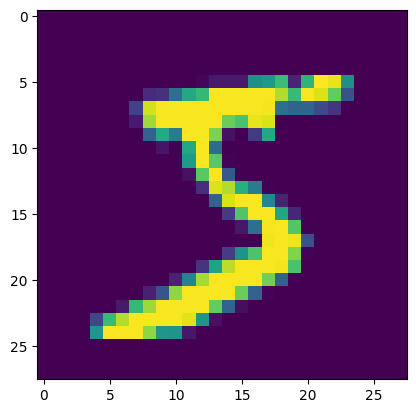

In [5]:
sample_image = datasets.MNIST('data', train = True, download= True)

for i , (image, label) in enumerate(sample_image):
    print("Label is ", label)
    plt.imshow(image)
    break

In [53]:



class MNISTClassifier(nn.Module):                           # nn.Module is a subclass from which we inherit
    def __init__(self):                                     # Here you define the structure
        super(MNISTClassifier, self).__init__()             
        self.layers = nn.Sequential(nn.Linear(28*28, 50),   # Create first layer: from 784 neurons to 50
                                    nn.ReLU(),              # Call activation function
                                    nn.Linear(50, 20),      # Second layer: from 50 neurons to 20
                                    nn.ReLU(),              # Call Activation function
                                    nn.Linear(20, 10))      # Last layer: from 20 neurons to 10
        # 10 because we have 10 categories of numbers from which we need to pick 1
        # If we would have wanted to classify images labeled "dog", "cat", "crocodile",
           # the final layer would have had 3 neurons.
        
    def forward(self, image, prints=False):                 # Function where you take the image though the FNN
        if prints: print('Image shape:', image.shape)
        image = image.view(-1, 28*28)                       # Flatten image: from [1, 28, 28] to [784]
        if prints: print('Image reshaped:', image.shape)
        out = self.layers(image)                            # Create Log Probabilities
        if prints: print('Out shape:', out.shape)
        
        return out

In [54]:
sample_image, sample_label = train_data[0]
print(f"Image.shape : {sample_image.shape}, image label is {sample_label}")

mnsit_classificer = MNISTClassifier()
mnsit_classificer(sample_image, prints = True)

Image.shape : torch.Size([1, 28, 28]), image label is 5
Image shape: torch.Size([1, 28, 28])
Image reshaped: torch.Size([1, 784])
Out shape: torch.Size([1, 10])


tensor([[ 0.1207, -0.2039, -0.1664, -0.1982,  0.2114,  0.2228,  0.1544, -0.1782,
          0.1075,  0.0137]], grad_fn=<AddmmBackward0>)

In [75]:
def get_accuracy(model, data, batch_size = 32):
    model.eval()

    data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size)
    correct_cases = 0
    total_cases = 0

    for (image, label) in iter(data_loader):
        out_label = model(image)

        prediction = out_label.max(dim =1)[1]

        correct_cases+= (prediction == label).sum().item()

        total_cases+= image.shape[0]
        return correct_cases/total_cases

In [92]:
def train_network(model, train_data, test_data, batchSize=20, epochs=5, learning_rate=0.01, weight_decay=0,
                 show_plot = True, show_acc = True):
    
    '''Trains the model and computes the average accuracy for train and test data.
    If enabled, it also shows the loss and accuracy over the iterations.'''
    
    print('Get data ready...')
    # Create dataloader for training dataset - so we can train on multiple batches
    # Shuffle after every epoch
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    
    # Losses & Iterations: to keep all losses during training (for plotting)
    losses = []
    iterations = []
    # Train and test accuracies: to keep their values also (for plotting)
    train_acc = []
    test_acc = []
    
    print('Training started...')
    iteration = 0
    # Train the data multiple times
    for epoch in range(epochs):
        
        for images, labels in iter(train_loader):
            # Set model in training mode:
            model.train()
            #images = images.view(-1, 28*28)
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels)
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save information after this iteration
            iterations.append(iteration)
            iteration += 1
            losses.append(loss)
            # Compute accuracy after this epoch and save
            train_acc.append(get_accuracy(model, train_data))
            test_acc.append(get_accuracy(model, test_data))
            
    
    # Show Accuracies
    # Show the last accuracy registered
    if show_acc:
        print("Final Training Accuracy: {}".format(train_acc[-1]))
        print("Final Testing Accuracy: {}".format(test_acc[-1]))
    
    # Create plots
    if show_plot:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.title("Loss Curve")
        losses_np = [loss.detach().numpy() for loss in losses]
        plt.plot(iterations[::20],losses_np[::20], label="Train", linewidth=4, color='#008C76FF')
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.subplot(1,2,2)
        plt.title("Accuracy Curve")
        plt.plot(iterations[::20], train_acc[::20], label="Train", linewidth=4, color='#9ED9CCFF')
        plt.plot(iterations[::20], test_acc[::20], label="Test", linewidth=4, color='#FAA094FF')
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()

Get data ready...
Training started...
Final Training Accuracy: 1.0
Final Testing Accuracy: 0.84375


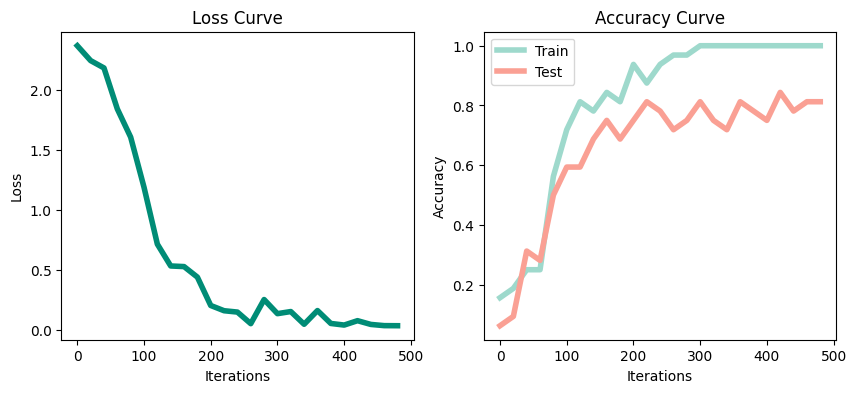

In [93]:
mnist_data = datasets.MNIST('data', train = True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)

# Training and Testing selection
mnist_train = mnist_data[:500]     # 500 training images
mnist_test = mnist_data[500:1000]  # 500 test images

# Create Model Instance
model1 = MNISTClassifier()

# Train...
train_network(model1, mnist_train, mnist_test, epochs=20)


In [66]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])